<a href="https://colab.research.google.com/github/ahmedSakka/Lung-Cancer-Detector/blob/main/Lung_Cancer_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Loading the dataset
data_dir = "/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
classes = ['Normal cases', 'Bengin cases', 'Malignant cases']

In [ ]:
# Finding the duplicate and corrupt images then deleting them
def find_duplicates(directory):
  images_hash = {}
  duplicates = 0
  corrupt_images = 0

  for root, _, files in os.walk(directory):
    for file in files:
      if file.endswith(('png', 'jpg', 'jpeg')):
        filepath = os.path.join(root, file)
        try:
          image = Image.open(filepath)
          image_array = np.array(image)

          # Creating the hash for the image according to its pixel values
          image_hash = hash(image_array.tobytes())
          # If the hash already exists that means the image is duplicated so delete it
          if image_hash in images_hash:
            os.remove(filepath)
            duplicates += 1
            print(f"Duplicate image removed: {file}")
          else:
            images_hash[image_hash] = filepath
        except Exception as e:
          # Removing corrupt images
          print(f"Corrupt image removed: {file}")
          os.remove(filepath)
          corrupt_images += 1

  print(f"Total duplicated images removed: {duplicates}")
  print(f"Total corrupt images removed: {corrupt_images}")

find_duplicates(data_dir)

Total duplicated images removed: 0
Total corrupt images removed: 0


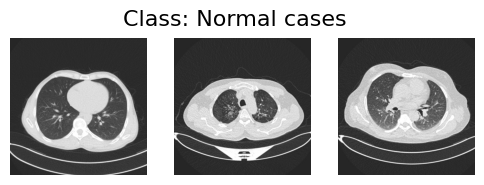

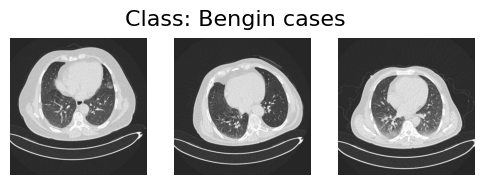

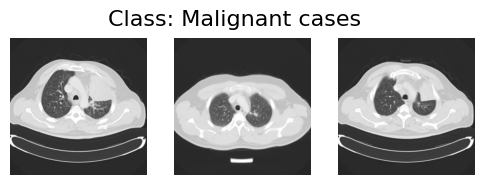

In [ ]:
# Showing three random images from the three classes and showing their labels
def show_random_images(directory, classes, num_of_images = 3):
  for cls in classes:
    class_dir = os.path.join(directory, cls)
    images = [i for i in os.listdir(class_dir) if i.endswith(('png' , 'jpg', 'jpeg'))]
    random_images = random.sample(images, num_of_images)

    plt.figure(figsize = (6,2))
    plt.suptitle(f"Class: {cls}", fontsize = 16)

    for i, img in enumerate(random_images):
      img_path = os.path.join(class_dir, img)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # Changing the image to be gray

      plt.subplot(1, num_of_images, i + 1)
      plt.imshow(img, cmap = 'gray')
      plt.axis('off')
    plt.show()

show_random_images(data_dir, classes)

In [4]:
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
  # Creating the training and testing directories
  train_dir = os.path.join(data_dir, 'train')
  test_dir = os.path.join(data_dir, 'test')

  # Creating the classes subfolders in the directories
  for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok = True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok = True)


  # Splitting the images and moving them to the training and testing directories
  for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)

    # Splitting the images into training (%80) and testing (%20)
    train_images, test_images = train_test_split(images, test_size = 0.2, random_state = 42)

    # Copying the training images into the training directory
    for img in train_images:
      source = os.path.join(class_dir, img) # Getting the source path
      destination = os.path.join(train_dir, cls, img) # Creating the destination path
      shutil.copy(source, destination) # Moving the image from the source into the destination

    # Copying the testing images into the testing directory
    for img in test_images:
      source = os.path.join(class_dir, img)
      destination = os.path.join(test_dir, cls, img)
      shutil.copy(source, destination)

print("Data has been successfuly split into training and testing classes.")
print(os.listdir(train_dir))
print(os.listdir(test_dir))

Data has been successfuly split into training and testing classes.
['Normal cases', 'Bengin cases', 'Malignant cases']
['Normal cases', 'Bengin cases', 'Malignant cases']


In [5]:
# Preparing the data for training and validation
def prepare_data(directory, classes, img_size = 128):
  images = []
  labels = []
  for class_idx, cls in enumerate(classes):
    class_dir = os.path.join(directory, cls)
    for file in os.listdir(class_dir):
      if file.endswith(('png', 'jpg', 'jpeg')):
        img_path = os.path.join(class_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          img = cv2.resize(img, (img_size, img_size))
          images.append(img)
          labels.append(class_idx)
  return np.array(images).astype('float32') / 255.0, np.array(labels)

# Loading and preprocessing the data
images, labels = prepare_data(data_dir, classes)
images = images[..., np.newaxis] # Adding a channel dimension

# Splitting the training data into training and validation
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels, random_state = 42)

# Balancing the training data using SMOTE technique
x_train_flat = x_train.reshape(x_train.shape[0], -1) # Flattening the data for SMOTE
smote = SMOTE(random_state = 42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_flat, y_train)
x_train_balanced = x_train_balanced.reshape(-1, 128, 128, 1) # Reshaping back to image format for training

# Create ImageDataGenerator for training
train_data_gen = ImageDataGenerator()

train_data = train_data_gen.flow(x_train_balanced, y_train_balanced, batch_size=32)

print(f"Number of training images: {x_train.shape[0]}")
print(f"Number of testing images: {x_test.shape[0]}")

Number of training images: 843
Number of testing images: 211


In [6]:
print(f"Before SMOTE: {np.unique(y_train, return_counts = True)}")
print(f"After SMOTE: {np.unique(y_train_balanced, return_counts = True)}")

Before SMOTE: (array([0, 1, 2]), array([324,  82, 437]))
After SMOTE: (array([0, 1, 2]), array([437, 437, 437]))


In [ ]:
#Defining the CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (128, 128, 1)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(len(classes), activation = 'softmax') # Output for the three classes with softmax
])

# Model compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

model.summary()

# Training the model
history = model.fit(
    train_data,
    validation_data = (x_test, y_test),
    epochs = 10,
    callbacks = [early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │         921,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 959,235 (3.66 MB)

 Trainable params: 959,235 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3649 - loss: 1.1550 - val_accuracy: 0.6825 - val_loss: 0.8133
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5713 - loss: 0.9450 - val_accuracy: 0.7678 - val_loss: 0.5319
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7902 - loss: 0.6488 - val_accuracy: 0.9005 - val_loss: 0.2768
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9391 - loss: 0.4262 - val_accuracy: 0.9147 - val_loss: 0.1987
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9723 - loss: 0.3448 - val_accuracy: 0.9573 - val_loss: 0.1634
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9764 - loss: 0.3130 - val_accuracy: 0.9573 - val_loss: 0.1644
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9863 - loss: 0.2978 - val_accuracy: 0.9526 - val_loss: 0.1481
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9904 - loss: 0.2906 - val_accuracy: 0.9621 - val_loss: 0.1318
Epo

In [ ]:
print("Training history:", history.history)

Training history: {'accuracy': [0.4050343334674835, 0.6086956262588501, 0.8276125192642212, 0.9435545206069946, 0.9755911231040955, 0.9748283624649048, 0.9885583519935608, 0.9908466935157776, 0.9916094541549683, 0.9923722147941589], 'loss': [1.0943498611450195, 0.8589723110198975, 0.5648753643035889, 0.40495577454566956, 0.34686562418937683, 0.32595598697662354, 0.2944451868534088, 0.27617689967155457, 0.2625690996646881, 0.24847346544265747], 'val_accuracy': [0.6824644804000854, 0.7677724957466125, 0.900473952293396, 0.9146919250488281, 0.9573459625244141, 0.9573459625244141, 0.9526066184043884, 0.9620853066444397, 0.9573459625244141, 0.9478672742843628], 'val_loss': [0.8132691383361816, 0.5318647623062134, 0.2768089771270752, 0.19868670403957367, 0.1634250283241272, 0.1644493043422699, 0.14805786311626434, 0.1318035125732422, 0.14793094992637634, 0.1621757447719574]}


In [ ]:
# Test data preparing and evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.9485 - loss: 0.1656
Test Loss: 0.1318
Test Accuracy: 0.9621


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step
Classification Report:
                 precision    recall  f1-score   support

   Normal cases       0.95      0.98      0.96        81
   Bengin cases       0.88      0.70      0.78        20
Malignant cases       0.98      1.00      0.99       110

       accuracy                           0.96       211
      macro avg       0.94      0.89      0.91       211
   weighted avg       0.96      0.96      0.96       211



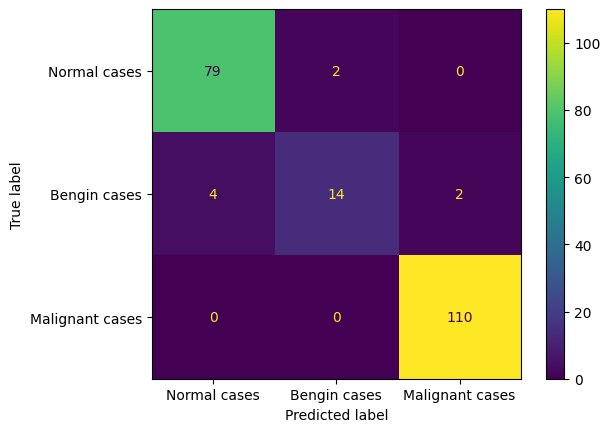

In [ ]:
# Predicting the classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # Converting the probabilities to indices
y_true = y_test # Getting the true labels from the test data

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
disp.plot()
plt.show()

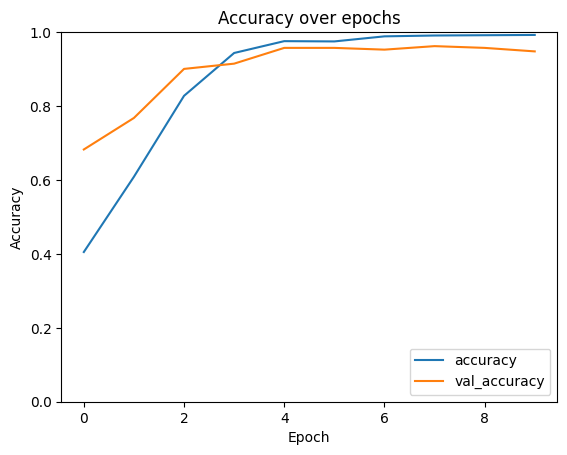

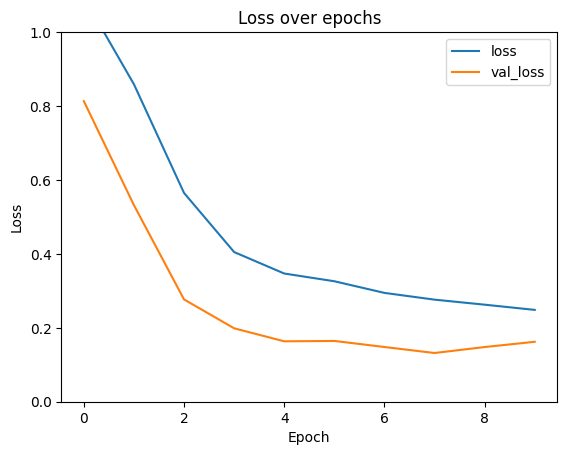

In [ ]:
# Plotting the accuracy and loss curves
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Loss over epochs')
plt.show()


In [ ]:
from google.colab import files
# Saving the trained model
model.save('lung_cancer_detection_model.h5')

# Downloading the saved model to my PC
try:
  files.download('lung_cancer_detection_model.h5')
  print("Model downloaded successfuly!")
except  Exception as e:
  print("Something went wrong while downloading the model")
  print(e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded successfuly!
